In [2]:
from datetime import datetime
import networkx as nx
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from LabelPropagation import LabelPropagation
import copy
from scipy.stats import betabinom

In [73]:
class graph:
    
    # model parameters
    m = None
    delta_repr = None # this is delta / m

    # graph state
    current_timestep = 0        

    '''
    initializes the PAM
    @param m >=1, number of edges added each timestep
    @param delta >= -m, determines the growth rule
    @param t >= 1, number of timesteps
    @constraint: delta >= -m
    '''
    def __init__(self, m, delta, t):
        assert delta >= -m, "parameter delta has to be >= -m"

        self.delta_repr = delta / m
        self.m = m
        
        #political orientation
        self.ors = np.linspace(0.5,5,10)
        self.votes = np.zeros(t) #.astype('str')

        # the representation of the PAM in terms of PAM with m = 1.
        self.G_repr = nx.Graph()

        #self.degr_distr = {}
        self.degr_distr = np.array([])
        
        self.iterativeGrowth(t)

    def growFurther(self, t):
        assert t >= self.current_timestep, "timestep given in iterativeGrowth is less than current timestep."
        self.iterativeGrowth(t)
        
    def growCoex(self, t):
        assert t >= self.current_timestep, "timestep given in iterativeGrowth is less than current timestep."
        self.coexGrowth(t) 

    def growFit(self, t, fit):
        assert t >= self.current_timestep, "timestep given in iterativeGrowth is less than current timestep."
        self.fitGrowth(t, fit) 

    def growLabel(self, t):
        for i in range(t):
            num = np.random.choice(self.current_timestep, p = np.ones(self.current_timestep)/self.current_timestep)
            neighs = np.array([n for n in pam.G[0]])
            opinion = np.random.choice(neighs, p = np.ones(len(neighs))/len(neighs))
            self.G.nodes[num]["type"] = self.G.nodes[opinion]["type"]
        
    '''
    iteratively grow G_repr until it has self.m*t nodes
    '''
    def iterativeGrowth(self, t):
        for i in tqdm(range(self.G_repr.number_of_nodes(), self.m*t)):
            # add new vertex (first vertex is called "0")
            self.G_repr.add_node(i)

            # add the appropriate edge with the heuristic  (8.2.1)
            self._addConnection()

        self.current_timestep = t
        self._collapseGraph()
        
    def coexGrowth(self, t):
        for i in tqdm(range(self.G.number_of_nodes(), t)):
            self.G_repr.add_nodes_from(np.arange(self.m) + self.m*i)
            
            # add the appropriate edge with the heuristic  (8.2.1)
            self._coexConnection()

        self.current_timestep = t
        self._coexcollapseGraph()

    def fitGrowth(self, t, fit):
        for i in tqdm(range(self.G.number_of_nodes(), t)):
            self.G_repr.add_nodes_from(np.arange(self.m) + self.m*i)
            
            # add the appropriate edge with the heuristic  (8.2.1)
            self._fitConnection(fit)
        self.current_timestep = t
        self._coexcollapseGraph()
        
    def _addConnection(self):
        # self loop probability
        dists = np.append(self.degr_distr, 1 + self.delta_repr)
        # select randomly the name of another vertex
        secondEndpoint = np.random.choice(len(dists), p = dists/np.sum(dists))
                      
        # maintain degree distr
        self.degr_distr = dists
        self.degr_distr[secondEndpoint] += 1

        # update self.G
        self.G_repr.add_edge(len(dists)-1, secondEndpoint)
        
    def _coexConnection(self):
        choices = np.array([])
        for i in range(self.m):
            dists = np.copy(self.degr_distr)

            # select randomly the name of another vertex, now, we cannot make a self-loop
            secondEndpoint = np.random.choice(len(dists[:-i or None]), p = dists[:-i or None]/np.sum(dists[:-i or None]))

            #copy the type of the other vertex
            choices = np.append(choices, self.votes[secondEndpoint//self.m])
            
            # maintain degree distr
            dists = np.append(dists, self.delta_repr)
            self.degr_distr = dists
            self.degr_distr[secondEndpoint] += 1

            # update self.G
            self.G_repr.add_edge(len(dists)-1, secondEndpoint)
        vote = np.append(self.votes, np.random.choice(choices, p = np.ones(len(choices))/len(choices)))
        self.votes = vote

    def _fitConnection(self, fit):
        choice = np.random.choice(self.ors, p = betabinom.pmf(np.arange(0, 10), 9, 3.5, 2))
        vote = np.repeat(self.votes, self.m)
        for i in range(self.m):
            dists = np.copy(self.degr_distr)
            distsfit = np.where(vote == choice, dists[:-i or None]*fit, dists[:-i or None])

            # select randomly the name of another vertex, now, we cannot make a self-loop
            secondEndpoint = np.random.choice(len(distsfit), p = distsfit/np.sum(distsfit))
            
            # maintain degree distr
            dists = np.append(dists, self.delta_repr)
            self.degr_distr = dists
            self.degr_distr[secondEndpoint] += 1

            # update self.G
            self.G_repr.add_edge(len(dists)-1, secondEndpoint)
        vote = np.append(self.votes, choice)
        self.votes = vote

    ''' 
    Explictely calculate the probabilities of attachment for each node. 
    '''
    def _calculateConnectionPMF(self):
        local_t = self.G_repr.number_of_nodes() - 1
        probabilities = np.zeros(self.G_repr.number_of_nodes())

        # self loop probability  (1 + δ)/(local_t(2 + δ) + (1 + δ))
        probabilities[-1] = (1 + self.delta_repr) / (local_t*(2 + self.delta_repr) + (1 + self.delta_repr))

        # other vertices probabilities:  (vertex_degr + δ)/(local_t(2 + δ) + (1 + δ))
        for i in range(len(probabilities)-1):

            # find degree of vertex with a self loop counting double
            adj = self.G_repr.adj[i] 
            vertex_degr = len(adj)+1 if (i in adj.keys()) else len(adj)

            probabilities[i]  = (vertex_degr + self.delta_repr)/(local_t*(2 + self.delta_repr) + (1 + self.delta_repr))

        
        assert abs(sum(probabilities) - 1) < 0.00001, "PMF does not sum to 1, but to {}".format(sum(probabilities))

        return probabilities

    '''
    (PAM_m,delta)_t is defined in terms of(PAM_1,delta/m)_mt.
    Thus to get the (PAM_m,delta)_t, the alternative representation has to be collapsed.
    '''
    
    def _collapseGraph(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(np.arange(self.current_timestep))
        for i in range(self.current_timestep):
            #self.votes[i] = np.random.choice(self.ors, p = np.ones(len(self.ors))/len(self.ors))
            self.votes[i] = np.random.choice(self.ors, p = betabinom.pmf(np.arange(0, 10), 9, 3.5, 2))
            self.G.nodes[i]["type"] = self.votes[i]
            nodes = np.arange(0, self.m) + self.m*i 
            edges = list(self.G_repr.edges(nodes))
            for edge in edges:
                self.G.add_edge(i, edge[1] // self.m)
                
    def _coexcollapseGraph(self):
        self.G = nx.Graph()
        self.G.add_nodes_from(np.arange(self.current_timestep))
        for i in range(self.current_timestep):
            self.G.nodes[i]["type"] = self.votes[i]
            nodes = np.arange(0, self.m) + self.m*i 
            edges = list(self.G_repr.edges(nodes))
            for edge in edges:
                self.G.add_edge(i, edge[1] // self.m)
                
    
    def draw(self):
        nx.draw_networkx(self.G)
        plt.show()
        
    def draw2(self):
        nx.draw_circular(self.G_repr)
        plt.show()
        
    def draw3(self):
        color_state_map = {0.5: 'red', 1: 'red', 1.5: 'yellow', 2: 'yellow', 2.5: 'blue', 3: 'blue', 3.5: 'blue', 4: 'green', 4.5: 'green', 5: 'orange'}
        label = {}
        for i in range(self.current_timestep):
            label[i] = self.G.nodes[i]["type"]
        nx.draw_networkx(self.G, node_color=[color_state_map[node[1]['type']] 
                    for node in self.G.nodes(data=True)], with_labels = False, labels = label, node_size=50)
        plt.show()

    def draw4(self):
        nx.draw_networkx(self.G, node_color=range(10), with_labels=False)
        plt.show()
    '''
    Returns distribution of typical distance:
    - the length of the shortest path between two randomly drawn nodes, given that they are connected
    @param sample: The number of randomly drawn 
    '''
    def typicalDistanceDistribution(self, sample=-1):

        all_shortest_paths = []
        if sample == -1:
            #dictionary of dictionaries dict[source][target] = path
            for source, destinations in nx.algorithms.shortest_path(self.G).items():
                for destination, path in destinations.items():
                    all_shortest_paths.append(path)
        else:
            sources = random.choices(list(self.G.nodes), k=sample)
            targets = random.choices(list(self.G.nodes), k=sample)
            for i in range(sample):
                all_shortest_paths.append(nx.algorithms.shortest_path(self.G, sources[i], targets[i]))

        # calculate pmf
        pmf = {}
        numberOfPaths = 0 #if sample > 0, then this will end up being equal to sample
        for path in all_shortest_paths:
            if (len(path)-1) in pmf:
                pmf[len(path)-1] += 1
            else: 
                pmf[len(path)-1] = 1
            numberOfPaths += 1

        print(numberOfPaths)

        #normalize the histogram (paths currently double counted)
        for key in pmf.keys():
            pmf[key] = pmf[key] / numberOfPaths

        assert abs(sum([v for v in pmf.values()]) - 1) < 0.00001, "pmf does not sum to one!!"

        return pmf

    '''
    Returns size of largest connected component (giant components)
    Note: Strictly speaking, we assume the GRG is highly connected, that is, as n -> \inf, 
    liminf of the ( size of the largest connected component / size of network) > 0.
    '''
    def getSizeOfGiantComponent(self):
        # get sorted list of size of all connected components
        component_sizes = [len(c) for c in sorted(nx.connected_components(self.G), key=len, reverse=True)]
        return component_sizes[0]

    '''
    store the networkx graph object
    '''
    def dumpGraph(self, fp='default'):
        import pickle

        if fp == 'default':
            fp = datetime.now().strftime("%H:%M:%S") + ".graph"
        elif not ".graph" in fp:
            fp = fp + ".graph"

        with open(fp, 'wb') as f:
            pickle.dump(self, f)

            
#ideetje al collapsen na de edge toe te voegen

In [87]:
pam = graph(2, 0, 2)

100%|██████████| 4/4 [00:00<00:00, 1338.64it/s]


In [88]:
pam.growFit(1000, 100)


100%|██████████| 998/998 [00:01<00:00, 635.13it/s]


In [89]:
pam.draw3()

KeyboardInterrupt: 

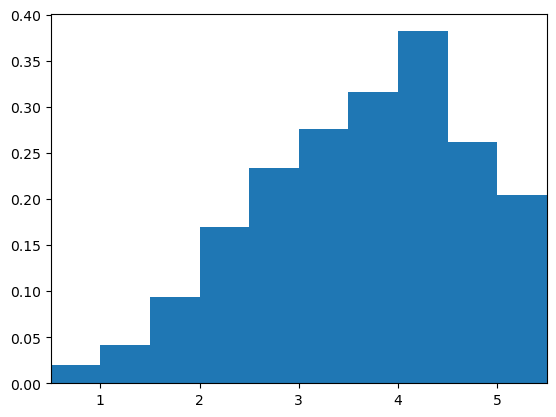

In [90]:
plt.hist(pam.votes, bins = np.linspace(0.5,5.5,11), density=True)
plt.xlim(0.5, 5.5)
plt.show()

In [13]:
a = np.empty((0,2), dtype=str)
a = np.append(a, np.array([['one', 'two']]), axis=0)
a

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [7]:
randinds = np.random.uniform(0, 10000, 9900).astype(int)
pam2 = copy.deepcopy(pam)

In [8]:
pam2.votes[randinds] = -1

In [9]:
adj_matrix = nx.adjacency_matrix(pam2.G).toarray()
labels = pam2.votes
label_propagation = LabelPropagation(adj_matrix, labels)
label_propagation.fit(labels, 1000, 1e-3)
label_propagation_output_labels = label_propagation.prediction()

C:\Users\samue\AppData\Local\Temp\ipykernel_22664\240376383.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(pam2.G).toarray()
  9%|▉         | 91/1000 [00:05<00:56, 16.21it/s]

The method stopped after 91 iterations with error=0.0000.


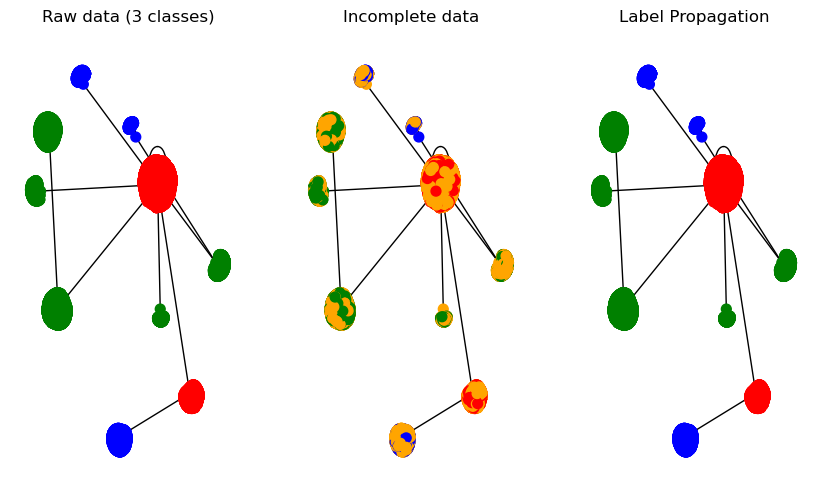

In [12]:
color_map = {-1: "orange", 0: "blue", 1: "green", 2: "red", 3: "cyan"}
input_labels_colors = [color_map[l] for l in pam.votes]
naked_labels_colors = [color_map[l] for l in pam2.votes]
lprop_labels_colors = [color_map[l] for l in label_propagation_output_labels]

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2)
ax3 = plt.subplot(1, 4, 3)

ax1.title.set_text("Raw data (3 classes)")
ax2.title.set_text("Incomplete data")
ax3.title.set_text("Label Propagation")

pos = nx.spring_layout(pam.G)
nx.draw(pam.G, ax=ax1, pos=pos, node_color=input_labels_colors, node_size=50)
nx.draw(pam.G, ax=ax2, pos=pos, node_color=naked_labels_colors, node_size=50)
nx.draw(pam.G, ax=ax3, pos=pos, node_color=lprop_labels_colors, node_size=50)

plt.show()

In [11]:
print(np.count_nonzero(label_propagation_output_labels == pam.votes)/10000)
print(2*10000/(10000*9999))

1.0
0.00020002000200020003


In [ ]:
def _collapseGraph2(self):
    adj = nx.to_numpy_array(self.G_repr).astype('int8')
    adjslice = np.lib.stride_tricks.as_strided(adj, shape=(self.current_timestep,self.current_timestep,self.m,self.m), strides=(2*self.current_timestep*self.m,self.m,self.current_timestep*self.m,1))
    newadj = np.zeros((self.current_timestep,self.current_timestep))
    for i in range(self.current_timestep):
        for j in range(self.current_timestep):
            newadj[i][j] = np.max(adjslice[i][j])
    self.G = nx.from_numpy_array(newadj)
        
def merge_nodes(G,nodes, new_node, attr_dict=None, **attr):
    
    G.add_node(new_node, attr_dict, **attr) # Add the 'merged' node
    
    for n1,n2,data in G.edges(data=True):
        # For all edges related to one of the nodes to merge,
        # make an edge going to or coming from the `new gene`.
        if n1 in nodes:
            G.add_edge(new_node,n2,data)
        elif n2 in nodes:
            G.add_edge(n1,new_node,data)
    
    for n in nodes: # remove the merged nodes
        G.remove_node(n)